In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import cv2
import numpy as np
import csv
from sklearn.utils import shuffle
from pylab import *
from matplotlib import gridspec
cdict = {'red': ((0.0, 1.0, 1.0),
                 (0.125, 1.0, 1.0),
                 (0.25, 1.0, 1.0),
                 (0.5625, 1.0, 1.0),
                 (1.0, 0.0, 0.0)),
         'green': ((0.0, 0.0, 0.0),
                   (0.25, 0.0, 0.0),
                   (0.5625, 1.0, 1.0),
                   (1.0, 1.0, 1.0)),
         'blue': ((0.0, 0.0, 0.0),
                  (0.5, 0.0, 0.0),
                  (1.0, 0.0, 0.0))}
my_cmap = matplotlib.colors.LinearSegmentedColormap('my_colormap',cdict,256)

%matplotlib inline

#datapath = '/home/microway/Shuo/CarND/CarND-BehaviorCloning-Project/data-given/'
data = pd.read_csv('/Users/Shuo/study/Project-predictive_study/Old_experiments/data_2016_I235E.csv',delimiter=',')

In [2]:
def load_data(data,datafolder='/Users/Shuo/study/Project-predictive_study/Old_experiments/Data_2016_DES_I235E/'):
    X_train = np.zeros((len(data),15,288,10))
    y_train = np.zeros((len(data),15,1440,1))
    volume = np.zeros((len(data),15,1440,1))
    for i in range(len(data)):
        with open(datafolder+'CSVs/'+data['X'][i], 'r') as f:
            X = list(csv.reader(f, delimiter=","))
            X = np.asarray(X)
            channels = np.unique(X[:,0])
            for channel in channels:
                index=X[:,0] == channel
                X_train[i,:,:,int(channel)] = X[index,1:]
        with open(datafolder+'Traffic_CSVs/'+data['y'][i], 'r') as f:
            y = list(csv.reader(f, delimiter=","))
            y = np.asarray(y)
            index=y[:,0] == '0'
            y_train[i,:,:,0] = y[index,1:]
            index_v=y[:,0] == '1'
            volume[i,:,:,0] = y[index_v,1:]
    return X_train,y_train,volume

In [3]:
X_train,y_train,volume = load_data(data)
print(X_train.shape)
print(y_train.shape)
print(volume.shape)

(346, 15, 288, 10)
(346, 15, 1440, 1)
(346, 15, 1440, 1)


In [4]:
def speed_reaggregate(y_train,volume):
    y_train_reag = np.zeros((len(y_train),15,288,1))
    for a in range((len(y_train))):
        for b in range(15):
            for c in range(288):
                s1 = y_train[a,b,5*c+0,0]
                s2 = y_train[a,b,5*c+1,0]
                s3 = y_train[a,b,5*c+2,0]
                s4 = y_train[a,b,5*c+3,0]
                s5 = y_train[a,b,5*c+4,0]
                   
                v1 = volume[a,b,5*c+0,0]
                v2 = volume[a,b,5*c+1,0]
                v3 = volume[a,b,5*c+2,0]
                v4 = volume[a,b,5*c+3,0]
                v5 = volume[a,b,5*c+4,0]
                
                if (v1+v2+v3+v4+v5 == 0):
                    y_train_reag[a,b,c,0] = (s1+s2+s3+s4+s5)/5
                else:    
                    y_train_reag[a,b,c,0] = (s1*v1+s2*v2+s3*v3+s4*v4+s5*v5)/(v1+v2+v3+v4+v5)
    return y_train_reag

In [5]:
y_train_reg = speed_reaggregate(y_train,volume)
print(X_train.shape)
print(y_train_reg.shape)

(346, 15, 288, 10)
(346, 15, 288, 1)


In [6]:
y_train = y_train_reg
print(np.count_nonzero(np.isnan(X_train)))
print(np.count_nonzero(np.isnan(y_train)))

0
0


In [7]:
def normalization(X_train):
    table = pd.read_csv('/Users/Shuo/study/Project-predictive_study/Old_experiments/stats_weather.csv',delimiter=',')
    for i in range(X_train.shape[-1]):
        mean = table['mean'][i]
        std = table['std'][i]
        X_train[:,:,:,i] = (X_train[:,:,:,i]-mean)/std
        X_train[np.isnan(X_train)] = 0
    return X_train
    
X_train = normalization(X_train)  

In [8]:
print(np.count_nonzero(np.isnan(X_train)))
print(np.count_nonzero(np.isnan(y_train)))

0
0


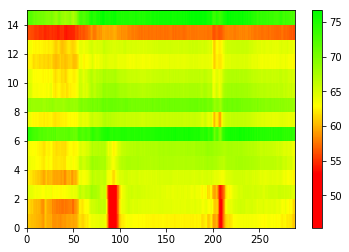

In [9]:
def convert_zero_2_mean(y_train):
    y_train[y_train==0] = np.nan
    avg = np.nanmean(y_train, axis=0)
    arrays = [avg for _ in range(y_train.shape[0])]
    AVG = np.stack(arrays, axis=0)
    index = np.isnan(y_train)
    y_train[index] = AVG[index]
    return y_train

y_train = convert_zero_2_mean(y_train)
    

def show_average_speed(y_train):
    speed_avg = np.mean(y_train, axis=0)
    plt.pcolor(speed_avg[:,:,0],cmap=my_cmap)
    colorbar()
    return speed_avg[:,:,0]

speed_avg = show_average_speed(y_train)



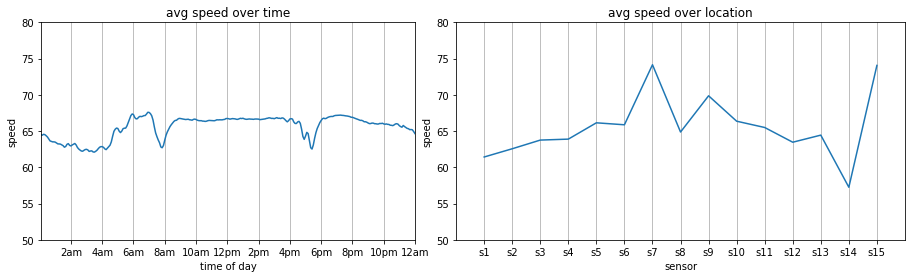

In [10]:
def show_speed_distribution_over_time_and_location(speed_avg):
    
    speed_over_time = np.mean(speed_avg,axis=0)
    speed_over_location = np.mean(speed_avg,axis=1)
    
    plt.figure(figsize=(12,4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[5,6]) 
    gs.update(left=0,right=1,hspace=0,wspace=0.1)
    
    ax0 = plt.subplot(gs[0])
    plt.plot(speed_over_time)
    
    ax0.set_xlim([0,287])
    ax0.set_ylim([50,80])
    xt = np.asarray([24,48,72,96,120,144,168,192,216,240,264,288])-1
    ax0.set_xticks(list(xt))
    ax0.set_xticklabels(['2am','4am','6am','8am','10am','12pm','2pm','4pm','6pm','8pm','10pm','12am'])
    ax0.set_xlabel('time of day')
    ax0.set_ylabel('speed')
    ax0.set_title('avg speed over time')
    ax0.xaxis.grid(True)
    
    ax1 = plt.subplot(gs[1])
    plt.plot(speed_over_location)
    
    ax1.set_xlim([-1,15])
    ax1.set_ylim([50,80])
    ax1.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
    ax1.set_xticklabels(['s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15'])
    ax1.set_xlabel('sensor')
    ax1.set_ylabel('speed')
    ax1.set_title('avg speed over location')
    ax1.xaxis.grid(True)
    
show_speed_distribution_over_time_and_location(speed_avg)
    
    

In [11]:
# time segmentation: every 2 hours, 12 binary channels
# location segmentatin every sensor, 13 binary channels
def set_time_binary(zeros_3D,i):
    X = zeros_3D
    X[:,:,24*i:24*(i+1)]=1
    return X
    
def set_location_binary(zeros_3D,i):
    X = zeros_3D
    X[:,i,:]=1
    return X

def add_spatial_temperal_info(X_train):
    
    time_channels = [set_time_binary(np.zeros(X_train.shape[:-1]),i) for i in range(12)]
    time_channel = np.stack(time_channels, axis=3)
    location_channels = [set_location_binary(np.zeros(X_train.shape[:-1]),i) for i in range(13)]
    location_channel = np.stack(location_channels, axis=3)
    X_train = np.concatenate((X_train,time_channel,location_channel),axis=3)
    return X_train

X_train = add_spatial_temperal_info(X_train)

print(X_train.shape)
print(y_train.shape)
len(X_train)


(346, 15, 288, 35)
(346, 15, 288, 1)


346

In [12]:
window=(15,12)
batch_size=4096
num_raw = len(X_train)
num_loc_stride = X_train.shape[1]-window[0]+1
num_time_stride = X_train.shape[2]-window[1]+1    
num = num_raw*num_loc_stride*num_time_stride
print(num_raw)
print(num_loc_stride)
print(num_time_stride)
print(num)

346
1
277
95842


In [13]:
# use 5*12 window the size of the training set will be boosted to 6GB! Use genrerator
from sklearn.model_selection import train_test_split
import sklearn
import itertools

def patches_generator(X_train,y_train,window=(15,12),batch_size=4096):
    
    num_raw = len(X_train)
    num_loc_stride = X_train.shape[1]-window[0]+1
    num_time_stride = X_train.shape[2]-window[1]+1
    
    num_samples = num_raw*num_loc_stride*num_time_stride
    
    index_structure = [range(num_raw),range(num_loc_stride),range(num_time_stride)]
    index_list = list(itertools.product(*index_structure))
    
    while 1: # Loop forever so the generator never terminates
        shuffle(index_list)
        for offset in range(0, num_samples, batch_size):
            batch_samples = index_list[offset:offset+batch_size]

            X_minibatch = []
            y_minibatch = []
            
            for batch_sample in batch_samples:
                
                X_patch = X_train[batch_sample[0],batch_sample[1]:batch_sample[1]+window[0],batch_sample[2]:batch_sample[2]+window[1],:]
                y_patch = y_train[batch_sample[0],batch_sample[1]:batch_sample[1]+window[0],batch_sample[2]:batch_sample[2]+window[1],:]
                
                X_minibatch.append(X_patch)
                y_minibatch.append(y_patch)

            X_minibatch = np.asarray(X_minibatch)
            y_minibatch = np.asarray(y_minibatch)
#             print(X_minibatch.shape)
#             print(y_minibatch.shape)
            yield sklearn.utils.shuffle(X_minibatch, y_minibatch)
#             yield (X_minibatch, y_minibatch)

In [14]:
from sklearn.model_selection import train_test_split
split = 0.2
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=split, random_state=0)

train_generator = patches_generator(X_train,y_train)
validation_generator = patches_generator(X_validation,y_validation)

In [15]:
from keras.models import Sequential
from keras.layers import Reshape, Dense, Conv2D, Conv2DTranspose, Flatten, Input, Dropout, MaxPooling2D, Activation
from keras.models import model_from_json
from keras.activations import relu, softmax, linear
from keras.layers.advanced_activations import PReLU
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ELU
from keras import regularizers

model = Sequential()
# 15*12*35
model.add(Conv2D(16, (5,5), strides=(1, 1),input_shape=(15, 12, 35),
                 data_format="channels_last",padding='valid',kernel_regularizer=regularizers.l2(0.0),
                activity_regularizer=regularizers.l2(0.001)))
model.add(ELU())
# 11*8*16
model.add(Conv2D(32, (5,5), strides=(1, 1),data_format="channels_last",padding='valid'
                ,kernel_regularizer=regularizers.l2(0.0),
                activity_regularizer=regularizers.l1(0.001)))
model.add(ELU())
# 7*4*32
# model.add(Flatten())
# # 

model.add(Conv2D(64, (1,1), strides=(1, 1),data_format="channels_last",padding='valid'
                ,kernel_regularizer=regularizers.l2(0.0),
                activity_regularizer=regularizers.l1(0.001)))
# model.add(Dense(100))
# model.add(ELU())
# model.add(Dense(1280))
# model.add(ELU())
# model.add(Reshape((5,8,32)))

model.add(Conv2DTranspose(16, (5,5), strides=(1, 1), data_format="channels_last",padding='valid'
                         ,kernel_regularizer=regularizers.l2(0.0),
                activity_regularizer=regularizers.l1(0.001)))
model.add(ELU())
# 7*10*16 
model.add(Conv2DTranspose(1, (5,5), strides=(1, 1),data_format="channels_last", padding='valid'
                         ,kernel_regularizer=regularizers.l2(0.0),
                activity_regularizer=regularizers.l1(0.001)))
# model.add(Activation('linear'))

model.compile(loss='mse', optimizer='adam')

# history_object = model.fit_generator(train_generator, samples_per_epoch=int(num*(1-split)), validation_data=validation_generator,nb_val_samples=int(num*split), nb_epoch=20, verbose =1)

history_object = model.fit_generator(train_generator, steps_per_epoch=int(num*(1-split)/batch_size), epochs=20, verbose=1,validation_data=validation_generator, validation_steps=int(num*split/batch_size))

Using TensorFlow backend.
/Users/Shuo/anaconda2/envs/CarND/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:2289: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Epoch 1/20
18/18 [==============================] - 44s - loss: 7458.5833 - val_loss: 5622.8840
Epoch 2/20
18/18 [==============================] - 42s - loss: 5227.5180 - val_loss: 4986.1356
Epoch 3/20
18/18 [==============================] - 41s - loss: 4826.3384 - val_loss: 4756.9975
Epoch 4/20
18/18 [==============================] - 41s - loss: 4665.4003 - val_loss: 4669.1724
Epoch 5/20
18/18 [==============================] - 42s - loss: 4581.7679 - val_loss: 4591.4296
Epoch 6/20
18/18 [==============================] - 46s - loss: 4535.1152 - val_loss: 4552.3319
Epoch 7/20
18/18 [==============================] - 41s - loss: 4503.4958 - val_loss: 4522.0051
Epoch 8/20
18/18 [==============================] - 40s - loss: 4476.4572 - val_loss: 4500.7383
Epoch 9/20
18/18 [==============================] - 40s - loss: 4459.2324 - val_loss: 4481.9428
Epoch 10/20
18/18 [==============================] - 40s - loss: 4445.0633 - val_loss: 4469.7732
Epoch 11/20
18/18 [====================

dict_keys(['loss', 'val_loss'])


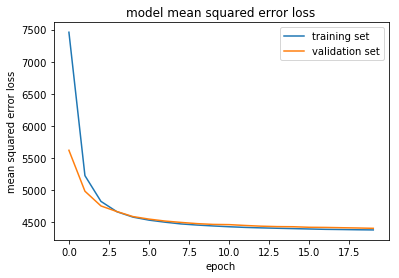

In [16]:
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [17]:
from keras.models import load_model
model.save('/Users/Shuo/study/Project-predictive_study/Speed_Pred_Stage1/model_patch_I235.h5')

20160812Dir1.csv


/Users/Shuo/anaconda2/envs/CarND/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:2289: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


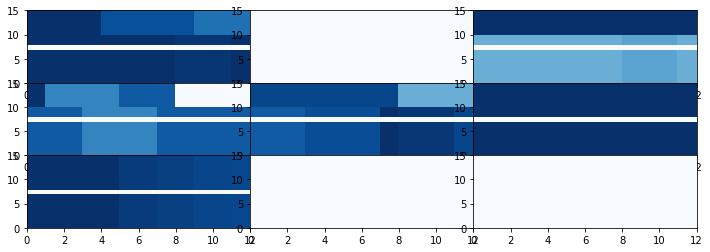

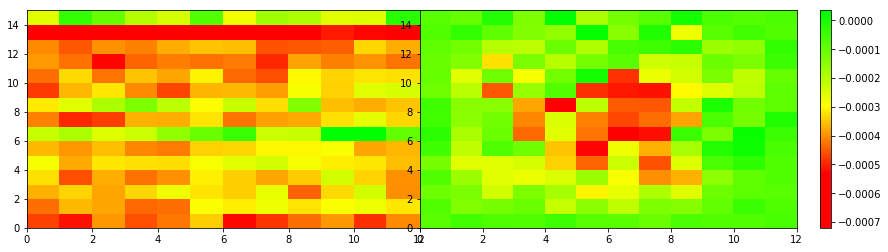

In [18]:
# check patch predictions
window=(15,12)
num_raw = len(X_train)
num_loc_stride = X_train.shape[1]-window[0]+1
num_time_stride = X_train.shape[2]-window[1]+1    
num = num_raw*num_loc_stride*num_time_stride


randnumber1 = np.random.randint(num_raw)
randnumber2 = np.random.randint(num_loc_stride)
randnumber3 = np.random.randint(num_time_stride)

print(data['X'][randnumber1])


X_patch = X_train[randnumber1,randnumber2:randnumber2+window[0],randnumber3:randnumber3+window[1],:]
y_patch = y_train[randnumber1,randnumber2:randnumber2+window[0]+2,randnumber3:randnumber3+window[1],0]

sample_patch = X_patch.reshape((1,)+X_patch.shape)

speed_prediction_patch = model.predict(sample_patch)
speed_prediction_patch = speed_prediction_patch[0,:,:,0]
speed_true_patch = y_patch


plt.figure(figsize=(12,4))
gs = gridspec.GridSpec(3, 3,hspace=0,wspace=0) 
for i in range(9):
    plt.subplot(gs[i])
    plt.pcolor(sample_patch[0,:,:,i],cmap=plt.cm.Blues)
plt.figure(figsize=(12,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[5,6]) 
gs.update(left=0,right=1,hspace=0,wspace=0)
plt.subplot(gs[0])
plt.pcolor(speed_true_patch,cmap=my_cmap)
plt.subplot(gs[1])
plt.pcolor(speed_prediction_patch,cmap=my_cmap)
colorbar()

In [19]:
canvas = np.empty((15,288)) * np.nan
canvas.shape

(15, 288)

20160904Dir1.csv


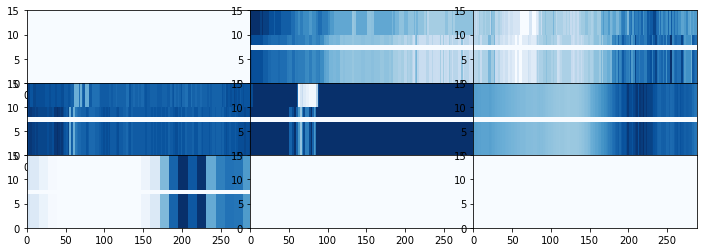

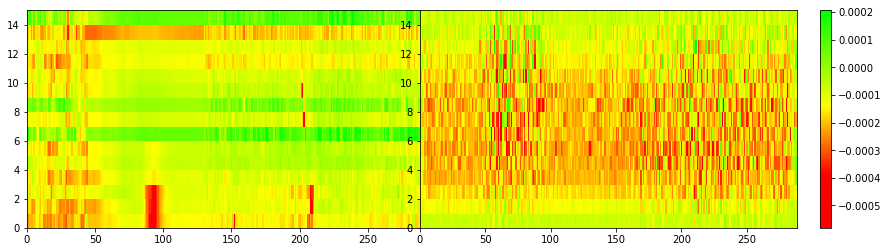

In [20]:
# check daily predictions
window=(15,12)
num_raw = len(X_train)
num_loc_stride = X_train.shape[1]-window[0]+1
num_time_stride = X_train.shape[2]-window[1]+1    
num = num_raw*num_loc_stride*num_time_stride

randnumber = np.random.randint(num_raw)
# randnumber = 31
print(data['X'][randnumber])

def stitch_patch_predictions(X_train,randnumber,num_loc_stride,num_time_stride,window):
    prediction = []
    sample_raw = X_train[randnumber,:,:,:]
    
    index_structure = [range(num_loc_stride),range(num_time_stride)]
    index_list = list(itertools.product(*index_structure))
    
    for index in index_list:
        X_patch = X_train[randnumber,index[0]:index[0]+window[0],index[1]:index[1]+window[1],:]
        sample_patch = X_patch.reshape((1,)+X_patch.shape)
        speed_prediction_patch = model.predict(sample_patch)
        speed_prediction_patch = speed_prediction_patch[0,:,:,0]
        canvas = np.empty((15,288)) * np.nan
        canvas[index[0]:index[0]+window[0]+2,index[1]:index[1]+window[1]] = speed_prediction_patch
        prediction.append(canvas)
    
    prediction = np.asarray(prediction)
    prediction = np.nanmean(prediction,axis=0)
    return prediction
             
sample_raw = X_train[randnumber,:,:,:]
speed_prediction = stitch_patch_predictions(X_train,randnumber,num_loc_stride,num_time_stride,window)
speed_true = y_train[randnumber,:,:,0]

plt.figure(figsize=(12,4))
gs = gridspec.GridSpec(3, 3,hspace=0,wspace=0) 
for i in range(9):
    plt.subplot(gs[i])
    plt.pcolor(sample_raw[:,:,i+1],cmap=plt.cm.Blues)
plt.figure(figsize=(12,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[5,6]) 
gs.update(left=0,right=1,hspace=0,wspace=0)
plt.subplot(gs[0])
plt.pcolor(speed_true,cmap=my_cmap)
plt.subplot(gs[1])
plt.pcolor(speed_prediction,cmap=my_cmap)
colorbar()



In [21]:
# plt.figure(figsize=(12,4))
# gs = gridspec.GridSpec(3, 3,hspace=0,wspace=0) 
# for i in range(9):
#     plt.subplot(gs[i])
#     plt.pcolor(sample_patch[0,:,:,i],cmap=plt.cm.Blues)
# plt.figure(figsize=(12,4))
# gs = gridspec.GridSpec(1, 2, width_ratios=[5,6]) 
# gs.update(left=0,right=1,hspace=0,wspace=0)
# plt.subplot(gs[0])
# plt.pcolor(speed_true_patch,cmap=my_cmap)
# plt.subplot(gs[1])
# plt.pcolor(speed_prediction_patch,cmap=my_cmap)
# colorbar()